In [2]:
import pandas as pd
import json
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
# Extracts player matches from json files 
file_list = []

folder_path = "./rta_player_data"
files_in_folder = os.listdir(folder_path)

# Filter out only files (excluding directories)
files = [file for file in files_in_folder if os.path.isfile(os.path.join(folder_path, file))]

for file in files:
    file_list.append('./rta_player_data/' + file)


In [4]:
def generate_drafts(user_data):
    battles = pd.read_json(user_data)
    battles = dict(battles.loc["battle_list"])['result_body']
    
    # holds all matches
    data_match = list()

    for x in range(len(battles)):
        
        # generic dict to store all features
        data = dict()

        # extracts hero pick order
        my_list = battles[x]['my_deck']
        enemy_list = battles[x]['enemy_deck']
        hero_deck = my_list["hero_list"]
        enemy_hero_deck = enemy_list["hero_list"]
        
        # checks for matches that do not have hero data
        # and skips that match
        team = battles[x]['teamBettleInfo']
        string_data_team = '{' + team + '}'
        data2 = json.loads(string_data_team)
        my_team_data = data2["my_team"]
        if not my_team_data:
            continue
        
        # extracts match pre bans and which side won
        my_preban = my_list['preban_list']
        enemy_preban = enemy_list['preban_list']
        is_win = battles[x]['iswin']
        
        # extract which user has the first turn
        is_first = 0
        for pick in hero_deck:
            first_pick = pick['first_pick']
            if first_pick == 1:
                is_first = 1
                break
            
        # heroes         
        for i in range(5):
            
            data['main' + str(i+1)] = hero_deck[i]['hero_code']
            data['enemy' + str(i+1)] = enemy_hero_deck[i]['hero_code']
            
        # pre-bans 
        for i in range(2):
            data['main_pre_b' + str(i+1)] = my_preban[i]
            data['enemy_pre_b' + str(i+1)] = enemy_preban[i] 
        
        # post-ban for main
        for i in range(5):
            if hero_deck[i]['ban'] == 1:
                data['main_post_b'] = str(hero_deck[i]['hero_code'])
        
        # post-ban for enemy     
        for i in range(5):
            if enemy_hero_deck[i]['ban'] == 1:
                data['enemy_post_b'] = str(enemy_hero_deck[i]['hero_code']) 
        
        # adds the user with first pick and winner to the match instance    
        data['is_first'] = is_first  
        data['is_win'] = is_win
        
        data_match.append(data)
    
    return data_match

In [5]:
# keep track of each match
drafts_dataset = []
for i in range(len(file_list)):
    res = generate_drafts(file_list[i])
    drafts_dataset.append(res)

# turns the 2d array to 1d and converts to dataframe
collapsed_arr = [item for sublist in drafts_dataset for item in sublist]
dataset = pd.DataFrame(collapsed_arr)


In [6]:
dataset

,main1,enemy1,main2,enemy2,main3,enemy3,main4,enemy4,main5,enemy5,main_pre_b1,enemy_pre_b1,main_pre_b2,enemy_pre_b2,main_post_b,enemy_post_b,is_first,is_win
0,c4144,c1159,c1126,c6017,c2022,c4004,c2047,c2103,c2099,c1137,c2016,c2090,c2109,c2089,c2099,c6017,0,2
1,c4144,c2022,c1159,c2008,c2101,c2050,c4004,c5089,c2099,c2089,c2016,c2090,c2109,c1133,c2099,c2089,0,2
2,c1159,c2089,c4144,c2024,c2022,c2070,c2047,c2009,c2099,c5082,c2016,c2090,c2109,c1133,c4144,c5082,0,2
3,c4144,c1121,c1159,c5089,c2022,c2070,c2047,c1034,c2089,c2079,c2016,c1133,c2109,c6062,c2089,c5089,0,1
4,c4144,c1159,c2022,c2089,c2090,c4004,c2101,c2050,c2047,c1145,c2016,c1133,c2109,c1118,c2047,c2089,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5363,c2109,c4003,c4004,c2070,c2090,c2132,c1055,c2016,c2073,c2027,c1151,c6062,c2089,c2008,c4004,c2132,1,1
5364,c4004,c1159,c2109,c2132,c6037,c2090,c1055,c6062,c2095,c4005,c1151,c2016,c2089,c2089,c2095,c4005,0,2
5365,c4004,c1159,c2109,c2070,c2132,c2090,c1055,c2074,c2073,c2071,c1151,c2016,c2089,c6062,c4004,c2090,0,1
5366,c2008,c1159,c2101,c2090,c2132,c1128,c2019,c4144,c1133,c2009,c1151,c2016,c2089,c2109,c1133,c2090,0,2


In [7]:
# sampled 50 random rows (matches)
rows = dataset.sample(n=50)
dataset_sample = pd.DataFrame(rows)
dataset_sample.reset_index(drop=True, inplace=True)


In [8]:
# checks the user whether they have the first pick and 
# keeps track of the hero picked first by that user
first_picked_col = []
for index, row in dataset_sample.iterrows():
    if row['is_first'] == 1:
        val = row['main1']
        first_picked_col.append(val)
    else:
        val = row['enemy1']
        first_picked_col.append(val)
        
dataset_sample['first_picked'] = first_picked_col

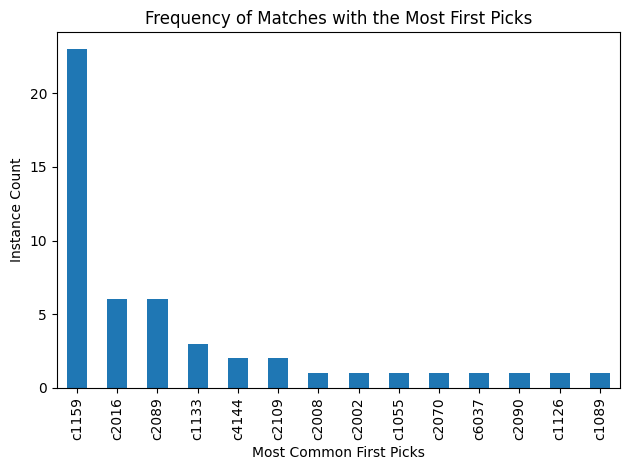

In [9]:
# Plots most common first picks 
graphMostFirstPick = dataset_sample['first_picked'].value_counts()
graphMostFirstPick.plot(kind='bar')
plt.xlabel('Most Common First Picks')
plt.ylabel('Instance Count')
plt.title('Frequency of Matches with the Most First Picks')
plt.tight_layout()
plt.show()

In [10]:
# Specify the file name
csv_file = 'drafts_dataset_sample.csv'

# Write the concatenated DataFrame to a CSV file
dataset_sample.to_csv(csv_file, index=False)



In [11]:
# Specify the file name
whole_dataset_csv_file = 'drafts_dataset.csv'

# Write the concatenated DataFrame to a CSV file
dataset.to_csv(whole_dataset_csv_file, index=False)

In [12]:
first_picked_col_all = []
for index, row in dataset.iterrows():
    if row['is_first'] == 1:
        val = row['main1']
        first_picked_col_all.append(val)
    else:
        val = row['enemy1']
        first_picked_col_all.append(val)
        
dataset['first_picked'] = first_picked_col_all

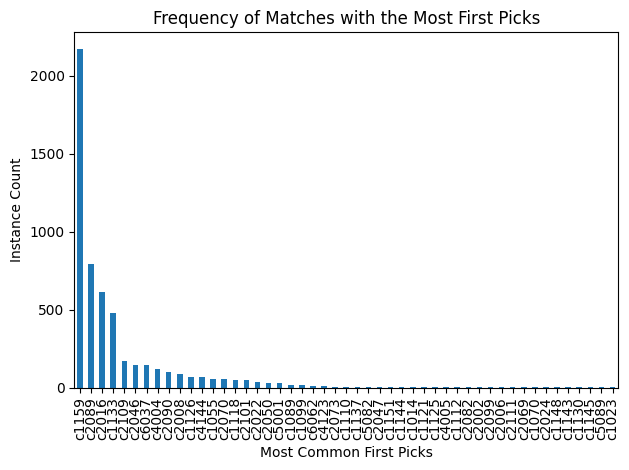

In [13]:
graphMostFirstPick = dataset['first_picked'].value_counts()
graphMostFirstPick.plot(kind='bar')
plt.xlabel('Most Common First Picks')
plt.ylabel('Instance Count')
plt.title('Frequency of Matches with the Most First Picks')
plt.tight_layout()
plt.show()

In [14]:
recommended_fp = [] 
for i in range(40):
    recommended_fp.append(dataset['first_picked'].value_counts().index[i])

In [15]:

recommended_fp

['c1159',
 'c2089',
 'c2016',
 'c1133',
 'c2109',
 'c2046',
 'c6037',
 'c4004',
 'c2090',
 'c2008',
 'c1126',
 'c4144',
 'c1055',
 'c2070',
 'c1118',
 'c2101',
 'c2022',
 'c2050',
 'c5001',
 'c1089',
 'c1099',
 'c6062',
 'c4123',
 'c2073',
 'c1110',
 'c1137',
 'c5082',
 'c2047',
 'c1151',
 'c1144',
 'c1014',
 'c1121',
 'c1125',
 'c4005',
 'c1112',
 'c2082',
 'c2002',
 'c2099',
 'c2006',
 'c2111']

In [33]:
def draft_response(m1, e1, m2, e2, m3, e3,
                   m4, e4, m5, e5, mpb1, mpb2, epb1, epb2):
    
    # list to keep track of heroes to not recommend to draft
    cannot_draft = []
    response = []
    
    copy_recommended_fp = recommended_fp

    cannot_draft.append(mpb1) 
    cannot_draft.append(mpb2)
    cannot_draft.append(epb1)
    cannot_draft.append(epb2)
    
    # Main first pick
    # "first pick" placeholder for first pick 
    if m1 == "" and e1 == "":
        
        for pick in copy_recommended_fp:
            for cannotpick in cannot_draft:
                if pick == cannotpick:
                    copy_recommended_fp.remove(pick) 
                    
        # returns the next avaliable item           
        return [copy_recommended_fp[0]]
    
    # main has fp
    if m2 == "" and m3 == "":
            
        cannot_draft.append(m1)
        cannot_draft.append(e1)
        cannot_draft.append(e2)
        
        for index, row in dataset.iterrows():
            
            # enemy fp -> main 1,2 
            # enemy 1,2,3 -> main 3,4
            # enemy 1,2,3,4,5 -> main 5
            
            # m2 m3 response into e1 e2  
                
                if row['is_first'] == 0 and row['enemy1'] == e1 and row['enemy2'] == e2:
                    
                    response1 = row['main2']
                    response2 = row['main3']
                    response.append([response1, response2])
                    responses_df = pd.DataFrame(response)
                    choices = responses_df.value_counts()[:20]
                    array = [pair for pair in choices.index] 
                    
                    flattened_list = [item for sublist in array for item in sublist]
                    data_singles = list(set(flattened_list))
                    
                    for pick in data_singles:
                        for cannotpick in cannot_draft:
                            if pick == cannotpick:
                                data_singles.remove(pick)
                                
                    return data_singles[:2]
    
    if m4 == "" and m5 == "":
            
        cannot_draft.append(m1)
        cannot_draft.append(e1)
        cannot_draft.append(e2)
        cannot_draft.append(m2)
        cannot_draft.append(m3)
        cannot_draft.append(e3)
        cannot_draft.append(e4)
        
        for index, row in dataset.iterrows():
            
            # enemy fp -> main 1,2 
            # enemy 1,2,3 -> main 3,4
            # enemy 1,2,3,4,5 -> main 5
            
            # m2 m3 response into e1 e2  
                
            if row['is_first'] == 0 and row['enemy3'] == e3 and row['enemy4'] == e4:
                
                response1 = row['main4']
                response2 = row['main5']
                response.append([response1, response2])
                responses_df = pd.DataFrame(response)
                choices = responses_df.value_counts()[:20]
                array = [pair for pair in choices.index] 
                
                flattened_list = [item for sublist in array for item in sublist]
                data_singles = list(set(flattened_list))
                
                for pick in data_singles:
                    for cannotpick in cannot_draft:
                        if pick == cannotpick:
                            data_singles.remove(pick)
                            
                return data_singles[:2]
    
    
    # enemy has fp 
    
    if m1 == "" and m2 == "":
            
        cannot_draft.append(e1) 
        
        for index, row in dataset.iterrows():
        
            # input e1
            # returns m1 m2
            if row['is_first'] == 0 and row['enemy1'] == e1:
                response1 = row['main1']
                response2 = row['main2']
                response.append([response1, response2])
                responses_df = pd.DataFrame(response)
                choices = responses_df.value_counts()[:20]
                array = [pair for pair in choices.index] 
                flattened_list = [item for sublist in array for item in sublist]
                data_singles = list(set(flattened_list))
                
                for pick in data_singles:
                    for cannotpick in cannot_draft:
                        if pick == cannotpick:
                            data_singles.remove(pick)
                            
                return data_singles[:2]
        
    if m3 == "" and m4 == "":    
            
        cannot_draft.append(e1) 
        cannot_draft.append(e2) 
        cannot_draft.append(e3)
        cannot_draft.append(m1) 
        cannot_draft.append(m2)  
        
        for index, row in dataset.iterrows():
            # input e1, e2, e3
            # returns m3 m4
            if row['is_first'] == 0 and row['enemy2'] == e2 and row['enemy3'] == e3:
                response1 = row['main3']
                response2 = row['main4']
                response.append([response1, response2])
                responses_df = pd.DataFrame(response)
                choices = responses_df.value_counts()[:20]
                array = [pair for pair in choices.index] 
                flattened_list = [item for sublist in array for item in sublist]
                data_singles = list(set(flattened_list))
                
                for pick in data_singles:
                    for cannotpick in cannot_draft:
                        # if any of the picks are in the recommended, then
                        if pick == cannotpick:
                            data_singles.remove(pick)
                            
                return data_singles[:2]
            
    if m5 == "":    
        cannot_draft.append(e1) 
        cannot_draft.append(e2) 
        cannot_draft.append(e3)
        cannot_draft.append(e4)
        cannot_draft.append(e5)
        cannot_draft.append(m1) 
        cannot_draft.append(m2) 
        cannot_draft.append(m3) 
        cannot_draft.append(m4)
        for index, row in dataset.iterrows():       
            # input e1, e2, e3, e4, e5
            # returns m5
            if row['is_first'] == 0 and  row['enemy4'] == e4 and row['enemy5'] == e5:
                response1 = row['main5']
                response.append([response1])
                responses_df = pd.DataFrame(response)
                choices = responses_df.value_counts()[:20]
                array = [pair for pair in choices.index] 
                flattened_list = [item for sublist in array for item in sublist]
                data_singles = list(set(flattened_list))
                
                for pick in data_singles:
                    for cannotpick in cannot_draft:
                        if pick == cannotpick:
                            data_singles.remove(pick)
                            
                return data_singles[:3]            
                
        else:
            if (m2 == "" and m3 == "") or (m1 == "" and m2 == "") or (m3 == "" and m4 == ""):
                print("ADSASDAS")        
                cannot_draft.append(e1) 
                cannot_draft.append(e2) 
                cannot_draft.append(e3)
                cannot_draft.append(e4)
                cannot_draft.append(e5)
                cannot_draft.append(m1) 
                cannot_draft.append(m2) 
                cannot_draft.append(m3) 
                cannot_draft.append(m4)
                for index, row in dataset.iterrows(): 
                    if row['is_first'] == 0: 
                        response1 = row['enemy3']
                        response2 = row['enemy4']
                        response.append([response1, response2])
                        responses_df = pd.DataFrame(response)
                        choices = responses_df.value_counts()[:20]
                        array = [pair for pair in choices.index] 
                        flattened_list = [item for sublist in array for item in sublist]
                        data_singles = list(set(flattened_list))
                        
                        for pick in data_singles:
                            for cannotpick in cannot_draft:
                                if pick == cannotpick:
                                    data_singles.remove(pick)
                                            
                        return data_singles[:3]
                    
            if m5 == "":
                print("asdasd")   
                cannot_draft.append(e1) 
                cannot_draft.append(e2) 
                cannot_draft.append(e3)
                cannot_draft.append(e4)
                cannot_draft.append(e5)
                cannot_draft.append(m1) 
                cannot_draft.append(m2) 
                cannot_draft.append(m3) 
                cannot_draft.append(m4)
                for index, row in dataset.iterrows(): 
                    if row['is_first'] == 0: 
                        response1 = row['enemy5']
                        response.append([response1])
                        responses_df = pd.DataFrame(response)
                        choices = responses_df.value_counts()[:20]
                        array = [pair for pair in choices.index] 
                        flattened_list = [item for sublist in array for item in sublist]
                        data_singles = list(set(flattened_list))
                        
                        for pick in data_singles:
                            for cannotpick in cannot_draft:
                                if pick == cannotpick:
                                    data_singles.remove(pick)
                                            
                        return data_singles[:3]
                        
            
                    
            output = "Invalid Input"
            return output

        


In [17]:
first_pick_main = "first pick"

# idea to take in a dynamic list?
# order m1, e1, m2, e2, m3, e3, m4, e4, m5, e5,

# test case pre ban Laia, Carmin, Clilias, Candy

# input "fp"
# returns m1 
draft_response("first pick", _, _, _, _, 
               _, _, _, _, _,"c1159", "c2008", "c2089", "c2109")

['c2089']

In [34]:
# input m1, e1, e2 ()
# returns m2 m3
draft_response('c2016', 'c2022', 'c5001', 'c4144', 'c2109', 'c2071', 'c2043', '', '', '',"c1159", "c2008", "c2089", "c2109")

asdasd


['c1137']

In [ ]:
# input m1,e1 e2, m2, m3, e4, e5
# returns m4, m5
# draft_response("c2016", "c4144", _, "c2022", _, 
#                _, _, _, _, _,"c1159", "c2008", "c2089", "c2109")

In [25]:
# test case pre ban Laia, Carmin, Clilias, Candy
# enemy fp ayufine
draft_response("c2022", "c6037", "c4144", "c6011", "c2070", 
               "c2050", "c1117", "c5089", "", "c2089","c1133", "c1118", "c2109", "c2016")

In [ ]:
# test case pre ban Laia, Carmin, Clilias, Candy
# enemy fp ayufine, e2, e3
# main picks m1, m2
# returns m3, m4
draft_response("c4144","c2016", "c2022", "c1133", _, 
               "c1118", _, _, _, _,
               "c1159", "c2008", "c2089", "c2109")

['c1151', 'c1091']

In [ ]:
# enemy 1-5
# main adin, destina, elena, ran
# enemy yufine, zio, nahkwol, cidd, jacko 
# returns m5
draft_response("c4144","c2016", "c2022", "c1133", "c1091", 
               "c1118", "c1151", "c1014", _, "c1130",
               "c1159", "c2008", "c2089", "c2109")

['c2020']

In [ ]:
draft_response("c1159", "c2016", "c2109", "c4004", "c2008", 
               "c2022", _, "c2071", _, _,"c1151", "c2089", "c2089", "c1133")

['c2046', 'c5089']